In [1]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
import pandas as pd
import re
import requests
from scipy.stats import norm
from scipy.signal import savgol_filter
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.patches import Rectangle
from scipy.stats import binom 

In [2]:
def extract_clinvar_truncation_variants(clinvar_df):
    #Pass the clinvar dataframe, extract early truncation mutations, and return the dataframe of truncation variants
    df_tmp = clinvar_df.loc[clinvar_df["Name"].str.contains("Ter",case = True, na=False)] # filter for only early Termination mutations
    df_tmp2 =clinvar_df.loc[clinvar_df["Name"].str.contains("fs",case = True, na=False)] # filter for only early Termination mutations
    trunc_df = pd.concat([df_tmp, df_tmp2], ignore_index = True)

    return trunc_df

def extract_gnomad_truncation_variants(gnomad_df):
    rows_to_drop = []
    for i in range(len(gnomad_df['Protein Consequence'])):
        if not "Ter" in str(gnomad_df["Protein Consequence"][i]): #and not "splice" in str(gnomad_df["VEP Annotation"][i]): 
                   rows_to_drop.append(i)
    gnomad_df = gnomad_df.drop(rows_to_drop)
    gnomad_df = gnomad_df.reset_index()
    return gnomad_df
# extract all missense variants (exclude ter or *) from clinvar

def extract_clinvar_missense_variants(clinvar_df):
    amino_acid_list = ['A','R','N','D','C','E','Q','G','H','I','L','K','M','F','P','S','T','W','Y','V']
    clinvar_missense_list = []
    clinvar_df.reset_index()
    #print(clinvar_df["Protein Consequence-MANE"])
    for i in range(len(clinvar_df["Protein Consequence-MANE"])):
        #if protein change[-1] == capital letter
        if str(clinvar_df["Protein Consequence-MANE"][i]) != "":
            if str(clinvar_df["Protein Consequence-MANE"][i])[-1] in amino_acid_list: #checks if last letter of protein change is a valid amino acid
                #print("TRUE at: "+str(i) )
                clinvar_missense_list.append(clinvar_df["Protein Consequence-MANE"][i])


    filter1 = clinvar_df['Protein Consequence-MANE'].isin(clinvar_missense_list)

    clinvar_missense_df = clinvar_df
    clinvar_missense_df =clinvar_missense_df[filter1]
    clinvar_missense_df = clinvar_missense_df.reset_index()
    return clinvar_missense_df # dataframe list of all missense variants from clinvar

def gnomad_extract_missense_rows(gnomad_df,transcript_id = "", drop_early_truncations = True):
    amino_acid_3letter = ['Ala','Arg','Asn','Asp','Cys','Glu','Gln','Gly','His','Ile','Leu','Lys','Met','Phe','Pro','Ser','Thr','Trp','Tyr','Val']
    #remove gnomad variants that aren't the correct transcript
    gnomad_df = gnomad_df[gnomad_df["Transcript"] == transcript_id].reset_index(drop=True)
    rows_to_drop = []
    if drop_early_truncations:
        for i in range(len(gnomad_df['Protein Consequence'])):
            if not str(gnomad_df["Protein Consequence"][i])[-3:] in amino_acid_3letter:
                rows_to_drop.append(i)
    gnomad_df = gnomad_df.drop(rows_to_drop)
    gnomad_df = gnomad_df.drop(gnomad_df[gnomad_df['VEP Annotation'] != "missense_variant"].index)
    gnomad_df = gnomad_df.reset_index() #must reset index bc df is indexed with missing values from removing non-missense variants
    
    return gnomad_df
    #gnomad_df['VEP Annotation'] == 'missense_variant'

def seperate_sex_gnomad_variants(gnomad_df):
    #"Allele Count", "Homozygote Count"(female homo), "Hemizygote Count"(male count)
    #female count = allele count - hemizygote count
    #female heterozygote count = female count - homozygote count
    female_rows_to_drop = []
    male_rows_to_drop = []
    for i in range(len(gnomad_df)):
        #if female count == 0; append to female_rows_to_drop
        #print("test @: "+str(i)) 
        female_count = int(gnomad_df["Allele Count"][i]) - int(gnomad_df["Hemizygote Count"][i])
        if female_count == 0:
            female_rows_to_drop.append(i)
        male_count = int(gnomad_df["Hemizygote Count"][i])
        if male_count == 0:
            male_rows_to_drop.append(i)
    female_gnomad_df = gnomad_df.drop(female_rows_to_drop)
    male_gnomad_df = gnomad_df.drop(male_rows_to_drop)
    male_gnomad_df = male_gnomad_df.reset_index()
    female_gnomad_df = female_gnomad_df.reset_index()

    return female_gnomad_df, male_gnomad_df
        


def clinvar_extract_residue_numbers(clinvar_df, remove_duplicates = True):
    residue_numbers = []
    clinvar_df = clinvar_df.reset_index()
    for i in range(len(clinvar_df)):
        residue_numbers.append((int(''.join(str(j) for j in re.findall(r"\d",clinvar_df['Protein Consequence-MANE'][i])))))#complicated bit of code to extract residue number/location from string)
    if remove_duplicates:
        residue_numbers = list(set(residue_numbers))
    
    return residue_numbers

def clinvar_add_residue_index_column(clinvar_missense_df):
    residue_numbers = []
    clinvar_missense_df = clinvar_df.reset_index()
    for i in range(len(clinvar_df)):
        residue_numbers.append((int(''.join(str(j) for j in re.findall(r"\d",clinvar_df['Protein Consequence-MANE'][i])))))#complicated bit of code to extract residue number/location from string)
    clinvar_missense_df.insert(3, "Residue Index", residue_numbers, True)
    
def gnomad_add_residue_index_column(gnomad_missense_df):
    residue_numbers = []
    gnomad_df = gnomad_df.reset_index() #must reset index bc df is indexed with missing values from removing non-missense variants
    for i in range(len(gnomad_df)):
        residue_numbers.append((int(''.join(str(j) for j in re.findall(r"\d", gnomad_df['Protein Consequence'][i])))))#complicated bit of code to extract residue number/location from string)
def gnomad_extract_residue_numbers(gnomad_df,remove_duplicates = True):
    #example string: "p.Val41Ala"
    residue_numbers = []
    gnomad_df = gnomad_df.reset_index() #must reset index bc df is indexed with missing values from removing non-missense variants
    for i in range(len(gnomad_df)):
        residue_numbers.append((int(''.join(str(j) for j in re.findall(r"\d", gnomad_df['Protein Consequence'][i])))))#complicated bit of code to extract residue number/location from string)
    if remove_duplicates:
        residue_numbers = list(set(residue_numbers))
    return residue_numbers
            # tmp2 = df_gnomad.iloc[i]
            # if tmp < PROT_LEN:
            #     residues_gnomad.append(tmp2)
    # df_residues_gnomad = pd.DataFrame(residues_gnomad)
def create_exclusive_variants_list(clinvar_df, gnomad_df):
    #pass in dataframe of clinvar missense variants and gnomad missense variants and it will return
    #exclusive or between gnomad list and clinvar list  
    #goal ==> create list of gnomad exclusive variants, clinvar exclusive variants, and list of variants found in both
    gnomad_missense_list = gnomad_df["Prot Consequence-ClinVar Format"].tolist()
    clinvar_missense_list = clinvar_df["Protein Consequence-MANE"].tolist()
    common_list = []
    
    #To create a new "appears in clinvar/gnomad" column for my original clinvar & gnomad dataframes, I must make a list and append "X" at the common indexes
    #print("gnomad_missense_list len:  "+str(len(gnomad_missense_list))+ "  clinvar_missense_list len:  "+ str(len(clinvar_missense_list)))
    in_both_clinvar_list = [None] *len(clinvar_df)
    in_both_gnomad_list = [None] *len(gnomad_df)

    for i in clinvar_missense_list[:]:
        if i in gnomad_missense_list:
            cl_index = clinvar_missense_list.index(i)
            in_both_clinvar_list[cl_index] = "X"
            gn_index = gnomad_missense_list.index(i)
            in_both_gnomad_list[gn_index] = "X"
            
            common_list.append(i)

    xgnomad_missense_df = gnomad_df[~gnomad_df['Prot Consequence-ClinVar Format'].isin(common_list)]
    xclinvar_missense_df = clinvar_df[~clinvar_df['Protein change'].isin(common_list)]
    
    clinvar_df["Found in gnomAD"] = in_both_clinvar_list
    gnomad_df["Found in ClinVar"] = in_both_gnomad_list
    
    # print ("clinvar_missense_df: " +str(len(clinvar_df)) +"  gnomad_df: "+str(len(gnomad_df)) +
    #        "  clinvar_exclusive_df: " +str(len(xclinvar_missense_df))+ 
    #        "  gnomad_exclusive_df: " + str(len(xgnomad_missense_df)) + 
    #        "  common_list: " + str(len(common_list)))
    common_missense_df = gnomad_df[gnomad_df['Prot Consequence-ClinVar Format'].isin(common_list)]
    return clinvar_df, gnomad_df, xclinvar_missense_df,xgnomad_missense_df,common_missense_df
    #remove common variants from xgnomad_list and xclinvar_list
    #then put these variants (with all their meta data) into 1 spreadsheet with multiple sheets
    #use a binary mask to select the rows to remove
    
def add_clinvar_format_variant_to_gnomad_df(gnomad_df):
    amino_acid_dict = {'Ala':'A', 'Arg':'R', 'Asn':'N', 'Asp':'D','Cys':'C', 'Glu':'E','Gln':'Q','Gly':'G','His':'H','Ile':'I','Leu':'L','Lys':'K','Met':'M','Phe':'F','Pro':'P','Ser':'S','Thr':'T','Trp':'W','Tyr':'Y','Val':'V'}
    tmp_var_list = []
    for i in range(len(gnomad_df)):
        tmp = gnomad_df["Protein Consequence"][i]
        if tmp[2:5] in amino_acid_dict and tmp[-3:] in amino_acid_dict: #ensure that this is a missense variant
            tmp_var_list.append(amino_acid_dict[tmp[2:5]] + tmp[5:-3] + amino_acid_dict[tmp[-3:]])
        
    gnomad_df.insert(12,'Prot Consequence-ClinVar Format',tmp_var_list,True)
    return gnomad_df

def add_clinvar_missense_MANE_column(clinvar_df):
    amino_acid_list = ['A','R','N','D','C','E','Q','G','H','I','L','K','M','F','P','S','T','W','Y','V']
    amino_acid_dict = {'Ala':'A', 'Arg':'R', 'Asn':'N', 'Asp':'D','Cys':'C', 'Glu':'E','Gln':'Q','Gly':'G','His':'H','Ile':'I','Leu':'L','Lys':'K','Met':'M','Phe':'F','Pro':'P','Ser':'S','Thr':'T','Trp':'W','Tyr':'Y','Val':'V','Ter':'*'}
    #pass in full clinvar dataframe, then adds a column for the MANE transcript alignment, and returns the amended dataframe

    #check if 'Protein Consequence-MANE' column isn't already a column
    tmp_var_list = []
    for i in range(len(clinvar_df)):
        tmp = clinvar_df["Name"][i]
        tmp_index = tmp.find("p.")+2 #starting index of the first amino acid in the name
        if tmp[tmp_index:tmp_index+3] in amino_acid_dict and tmp[-4:-1] in amino_acid_dict:  #first check if both 3 letters a.a.s in Name are an amino acid by checking if it is a key in a.a._dict
            tmp_var_list.append(amino_acid_dict[tmp[tmp_index:tmp_index+3]] + tmp[tmp_index+3:-4] + amino_acid_dict[tmp[-4:-1]])
        else:
            tmp_var_list.append("")

    clinvar_df.insert(3,'Protein Consequence-MANE',tmp_var_list,True) # This bit of code adds a protein consequence column with the MANE annotated variant

    len(clinvar_df)
    return clinvar_df

def drop_extra_clinvar_columns(clinvar_df):
    clinvar_df=clinvar_df.drop(columns=['index','Name','Gene(s)','GRCh37Chromosome','GRCh37Location','GRCh38Chromosome','GRCh38Location','Somatic clinical impact',
                                            'Somatic clinical impact date last evaluated','Somatic clinical impact review status','Oncogenicity classification',
                                            'Oncogenicity date last evaluated','Oncogenicity review status','Unnamed: 24'])

    return clinvar_df
def drop_extra_gnomad_columns(gnomad_df):
    gnomad_df = gnomad_df.drop(columns=['index','Chromosome','Position','rsIDs','Reference','Alternate','HGVS Consequence','Flags','Allele Number', 'Allele Frequency',
                                 'GroupMax FAF group','GroupMax FAF frequency','cadd','revel_max','spliceai_ds_max','pangolin_largest_ds','phylop','sift_max','polyphen_max',
                                 'Allele Count African/African American','Allele Number African/African American','Homozygote Count African/African American',
                                 'Hemizygote Count African/African American','Allele Count Admixed American','Allele Number Admixed American',
                                 'Homozygote Count Admixed American','Hemizygote Count Admixed American','Allele Count Ashkenazi Jewish','Allele Number Ashkenazi Jewish',
                                 'Homozygote Count Ashkenazi Jewish','Hemizygote Count Ashkenazi Jewish','Allele Count East Asian','Allele Number East Asian',
                                 'Homozygote Count East Asian','Hemizygote Count East Asian','Allele Count European (Finnish)','Allele Number European (Finnish)',
                                 'Homozygote Count European (Finnish)','Hemizygote Count European (Finnish)','Allele Count Middle Eastern','Allele Number Middle Eastern',
                                 'Homozygote Count Middle Eastern','Hemizygote Count Middle Eastern','Allele Count European (non-Finnish)','Allele Number European (non-Finnish)',
                                 'Homozygote Count European (non-Finnish)','Hemizygote Count European (non-Finnish)','Allele Count Amish','Allele Number Amish',
                                 'Homozygote Count Amish','Hemizygote Count Amish','Allele Count South Asian','Allele Number South Asian','Homozygote Count South Asian',
                                 'Hemizygote Count South Asian','Allele Count Remaining','Allele Number Remaining','Homozygote Count Remaining','Hemizygote Count Remaining'])
    return gnomad_df

def assemble_indexed_residue_list(residues,prot_len):
    indexed_residues = [0]*prot_len
    for i in range(prot_len):
        if i in residues:
            indexed_residues[i] = 1
    return indexed_residues       
            
#create the excel sheet
def create_excel(xclinvar_missense_df,xgnomad_missense_df,common_missense_df,gene_name):
    with pd.ExcelWriter('excel_sheets/'+gene_name+'_multidb.xlsx') as writer:  
        xgnomad_missense_df.to_excel(writer, sheet_name='gnomad_exclusive_mis_var')
        xclinvar_missense_df.to_excel(writer, sheet_name='clinvar_exclusive_mis_var')
        common_missense_df.to_excel(writer, sheet_name='found_in_both_mis_var')

        
def convolve_v3(rsd_index_list, protein_len, window_size=5):
    #if this gives a double scalar runtime warning, it is likely due to gnomad_extract_missense_rows(gnomad_df,transcript_id,True) being called with the incorrect transcript_id
    #double check that the transcript_id being passed to gnomad_extract_missense_rows(), or gnomad_df will be empty, tripping the runtime warning
    n = window_size*2
    p = 0.5
    r_values = list(range(n+1))
    dist = [binom.pmf(r,n,p) for r in r_values ]
    # plt.bar(r_values, dist)
    # plt.show()
    norm = [float(i)/max(dist) for i in dist]
    
    convolved_list = []
    for i in range(protein_len):
        tmp = 0
        
        offset_numerator = max([(0 if (i-protein_len+int(len(dist)/2)) <0 else (i-protein_len+int(len(dist)/2))), 
                             (0 if -1*(i-int(len(dist)/2)) < 0 else -1*(i-int(len(dist)/2)))])
        #print(offset_numerator)
        
        for j in range(len(dist)):
            #if i - int(len(dist)/2) >0:
            #checks if the j values are within the range of the i values I guess *** go back and check this
            if i-int(len(dist)/2)+j >= 0 and i-int(len(dist)/2)+j < protein_len:
                tmp += rsd_index_list[i-int(len(dist)/2)+j]*dist[j]
            
        convolved_list.append(tmp*(1+(offset_numerator/(len(dist)/2))))
    return convolved_list
    #first part of the loop is to determine percentage of curve is actually within range of the protein
        
    #define binomial distribution with discrete values (ie a list from 0-10 for a window size of 5)
    
def underline_sensitive_regions(seq,y_diff):
    neg_indexes = [i for i in range(len(y_diff)) if y_diff[i] < 0] #indexes of all negative values from y_diff
    tmp1 = ""
    for i in range(len(seq)):
        if i in neg_indexes:
            tmp1+=("\033[4m"+seq[i]+"\033[0m")
        else:
            tmp1+=(""+seq[i]+"")
    return tmp1

def extract_variants_within_range(df,db_str, min_residue, max_residue):
    variants = []
    if db_str.lower() == "gnomad":
        for i in range(len(df)):
            residue_number = (int(''.join(str(j) for j in re.findall(r"\d", df['Prot Consequence-ClinVar Format'][i]))))#complicated bit of code to extract residue number/location from string)
            if min_residue <= residue_number <= max_residue:
                variants.append(df['Prot Consequence-ClinVar Format'][i])
    if db_str.lower() == "clinvar":
        for i in range(len(df)):
            residue_number = (int(''.join(str(j) for j in re.findall(r"\d", df['Protein Consequence-MANE'][i]))))#complicated bit of code to extract residue number/location from string)
            if min_residue <= residue_number <= max_residue:
                variants.append(df['Protein Consequence-MANE'][i])
    return variants

In [3]:
nlgn1_seq = "MALPRCTWPNYVWRAVMACLVHRGLGAPLTLCMLGCLLQAGHVLSQKLDDVDPLVATNFGKIRGIKKELNNEILGPVIQFLGVPYAAPPTGERRFQPPEPPSPWSDIRNATQFAPVCPQNIIDGRLPEVMLPVWFTNNLDVVSSYVQDQSEDCLYLNIYVPTEDVKRISKECARKPGKKICRKGGPLTKKQTDDLGDNDGAEDEDIRDSGGPKPVMVYIHGGSYMEGTGNLYDGSVLASYGNVIVITVNYRLGVLGFLSTGDQAAKGNYGLLDLIQALRWTSENIGFFGGDPLRITVFGSGAGGSCVNLLTLSHYSEGNRWSNSTKGLFQRAIAQSGTALSSWAVSFQPAKYARMLATKVGCNVSDTVELVECLQKKPYKELVDQDIQPARYHIAFGPVIDGDVIPDDPQILMEQGEFLNYDIMLGVNQGEGLKFVENIVDSDDGISASDFDFAVSNFVDNLYGYPEGKDVLRETIKFMYTDWADRHNPETRRKTLLALFTDHQWVAPAVATADLHSNFGSPTYFYAFYHHCQTDQVPAWADAAHGDEVPYVLGIPMIGPTELFPCNFSKNDVMLSAVVMTYWTNFAKTGDPNQPVPQDTKFIHTKPNRFEEVAWTRYSQKDQLYLHIGLKPRVKEHYRANKVNLWLELVPHLHNLNDISQYTSTTTKVPSTDITFRPTRKNSVPVTSAFPTAKQDDPKQQPSPFSVDQRDYSTELSVTIAVGASLLFLNILAFAALYYKKDKRRHDVHRRCSPQRTTTNDLTHAQEEEIMSLQMKHTDLDHECESIHPHEVVLRTACPPDYTLAMRRSPDDVPLMTPNTITMIPNTIPGIQPLHTFNTFTGGQNNTLPHPHPHPHSHSTTRV"
nlgn2_seq = "MWLLALCLVGLAGAQRGGGGPGGGAPGGPGLGLGSLGEERFPVVNTAYGRVRGVRRELNNEILGPVVQFLGVPYATPPLGARRFQPPEAPASWPGVRNATTLPPACPQNLHGALPAIMLPVWFTDNLEAAATYVQNQSEDCLYLNLYVPTEDGPLTKKRDEATLNPPDTDIRDPGKKPVMLFLHGGSYMEGTGNMFDGSVLAAYGNVIVATLNYRLGVLGFLSTGDQAAKGNYGLLDQIQALRWLSENIAHFGGDPERITIFGSGAGASCVNLLILSHHSEGLFQKAIAQSGTAISSWSVNYQPLKYTRLLAAKVGCDREDSAEAVECLRRKPSRELVDQDVQPARYHIAFGPVVDGDVVPDDPEILMQQGEFLNYDMLIGVNQGEGLKFVEDSAESEDGVSASAFDFTVSNFVDNLYGYPEGKDVLRETIKFMYTDWADRDNGEMRRKTLLALFTDHQWVAPAVATAKLHADYQSPVYFYTFYHHCQAEGRPEWADAAHGDELPYVFGVPMVGATDLFPCNFSKNDVMLSAVVMTYWTNFAKTGDPNQPVPQDTKFIHTKPNRFEEVVWSKFNSKEKQYLHIGLKPRVRDNYRANKVAFWLELVPHLHNLHTELFTTTTRLPPYATRWPPRPPAGAPGTRRPPPPATLPPEPEPEPGPRAYDRFPGDSRDYSTELSVTVAVGASLLFLNILAFAALYYKRDRRQELRCRRLSPPGGSGSGVPGGGPLLPAAGRELPPEEELVSLQLKRGGGVGADPAEALRPACPPDYTLALRRAPDDVPLLAPGALTLLPSGLGPPPPPPPPSLHPFGPFPPPPPTATSHNNTLPHPHSTTRV"
nlgn3_seq = "MWLRLGPPSLSLSPKPTVGRSLCLTLWFLSLALRASTQAPAPTVNTHFGKLRGARVPLPSEILGPVDQYLGVPYAAPPIGEKRFLPPEPPPSWSGIRNATHFPPVCPQNIHTAVPEVMLPVWFTANLDIVATYIQEPNEDCLYLNVYVPTEDVKRISKECARKPNKKICRKGGSGAKKQGEDLADNDGDEDEDIRDSGAKPVMVYIHGGSYMEGTGNMIDGSILASYGNVIVITLNYRVGVLGFLSTGDQAAKGNYGLLDQIQALRWVSENIAFFGGDPRRITVFGSGIGASCVSLLTLSHHSEGLFQRAIIQSGSALSSWAVNYQPVKYTSLLADKVGCNVLDTVDMVDCLRQKSAKELVEQDIQPARYHVAFGPVIDGDVIPDDPEILMEQGEFLNYDIMLGVNQGEGLKFVEGVVDPEDGVSGTDFDYSVSNFVDNLYGYPEGKDTLRETIKFMYTDWADRDNPETRRKTLVALFTDHQWVEPSVVTADLHARYGSPTYFYAFYHHCQSLMKPAWSDAAHGDEVPYVFGVPMVGPTDLFPCNFSKNDVMLSAVVMTYWTNFAKTGDPNKPVPQDTKFIHTKANRFEEVAWSKYNPRDQLYLHIGLKPRVRDHYRATKVAFWKHLVPHLYNLHDMFHYTSTTTKVPPPDTTHSSHITRRPNGKTWSTKRPAISPAYSNENAQGSWNGDQDAGPLLVENPRDYSTELSVTIAVGASLLFLNVLAFAALYYRKDKRRQEPLRQPSPQRGAGAPELGAAPEEELAALQLGPTHHECEAGPPHDTLRLTALPDYTLTLRRSPDDIPLMTPNTITMIPNSLVGLQTLHPYNTFAAGFNSTGLPHSHSTTRV"
nlgn4x_seq = "MSRPQGLLWLPLLFTPVCVMLNSNVLLWLTALAIKFTLIDSQAQYPVVNTNYGKIRGLRTPLPNEILGPVEQYLGVPYASPPTGERRFQPPEPPSSWTGIRNTTQFAAVCPQHLDERSLLHDMLPIWFTANLDTLMTYVQDQNEDCLYLNIYVPTEDDIHDQNSKKPVMVYIHGGSYMEGTGNMIDGSILASYGNVIVITINYRLGILGFLSTGDQAAKGNYGLLDQIQALRWIEENVGAFGGDPKRVTIFGSGAGASCVSLLTLSHYSEGLFQKAIIQSGTALSSWAVNYQPAKYTRILADKVGCNMLDTTDMVECLRNKNYKELIQQTITPATYHIAFGPVIDGDVIPDDPQILMEQGEFLNYDIMLGVNQGEGLKFVDGIVDNEDGVTPNDFDFSVSNFVDNLYGYPEGKDTLRETIKFMYTDWADKENPETRRKTLVALFTDHQWVAPAVATADLHAQYGSPTYFYAFYHHCQSEMKPSWADSAHGDEVPYVFGIPMIGPTELFSCNFSKNDVMLSAVVMTYWTNFAKTGDPNQPVPQDTKFIHTKPNRFEEVAWSKYNPKDQLYLHIGLKPRVRDHYRATKVAFWLELVPHLHNLNEIFQYVSTTTKVPPPDMTSFPYGTRRSPAKIWPTTKRPAITPANNPKHSKDPHKTGPEDTTVLIETKRDYSTELSVTIAVGASLLFLNILAFAALYYKKDKRRHETHRRPSPQRNTTNDIAHIQNEEIMSLQMKQLEHDHECESLQAHDTLRLTCPPDYTLTLRRSPDDIPLMTPNTITMIPNTLTGMQPLHTFNTFSGGQNSTNLPHGHSTTRV"
nlgn4y_seq = "MLRPQGLLWLPLLFTSVCVMLNSNVLLWITALAIKFTLIDSQAQYPVVNTNYGKIQGLRTPLPSEILGPVEQYLGVPYASPPTGERRFQPPESPSSWTGIRNATQFSAVCPQHLDERFLLHDMLPIWFTTSLDTLMTYVQDQNEDCLYLNIYVPMEDDIHEQNSKKPVMVYIHGGSYMEGTGNMIDGSILASYGNVIVITINYRLGILGFLSTGDQAAKGNYGLLDQIQALRWIEENVGAFGGDPKRVTIFGSGAGASCVSLLTLSHYSEGLFQKAIIQSGTALSSWAVNYQPAKYTRILADKVGCNMLDTTDMVECLKNKNYKELIQQTITPATYHIAFGPVIDGDVIPDDPQILMEQGEFLNYDIMLGVNQGEGLKFVDGIVDNEDGVTPNDFDFSVSNFVDNLYGYPEGKDTLRETIKFMYTDWADKENPETRRKTLVALFTDHQWVAPAVATADLHAQYGSPTYFYAFYHHCQSEMKPSWADSAHGDEVPYVFGIPMIGPTELFSCNFSKNDVMLSAVVMTYWTNFAKTGDPNQPVPQDTKFIHTKPNRFEEVAWSKYNPKDQLYLHIGLKPRVRDHYRATKVAFWLELVPHLHNLNEIFQYVSTTTKVPPPDMTSFPYGTRRSPAKIWPTTKRPAITPANNPKHSKDPHKTGPEDTTVLIETKRDYSTELSVTIAVGASLLFLNILAFAALYYKKDKRRHETHRHPSPQRNTTNDITHIQNEEIMSLQMKQLEHDHECESLQAHDTLRLTCPPDYTLTLRRSPDDIPFMTPNTITMIPNTLMGMQPLHTFKTFSGGQNSTNLPHGHSTTRV"
nlgn1_transcript_id = "ENST00000457714.5"
nlgn2_transcript_id = "ENST00000302926.7"
nlgn3_transcript_id = "ENST00000358741.4"
nlgn4x_transcript_id = "ENST00000381095.8"
#Reference lengths: NLGN1-863 NLGN2-835 NLGN3-848 NLGN4X-816 NLGN4Y-816
nlgn1_len = 863
nlgn2_len = 835
nlgn3_len = 848
nlgn4x_len = 816

gene: NLGN1


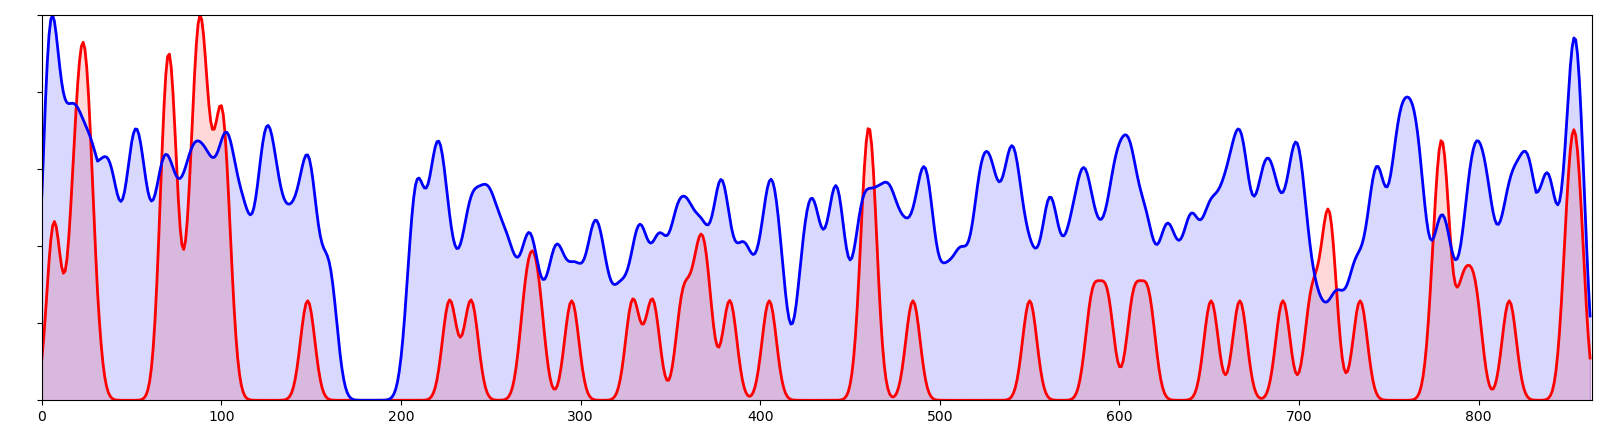

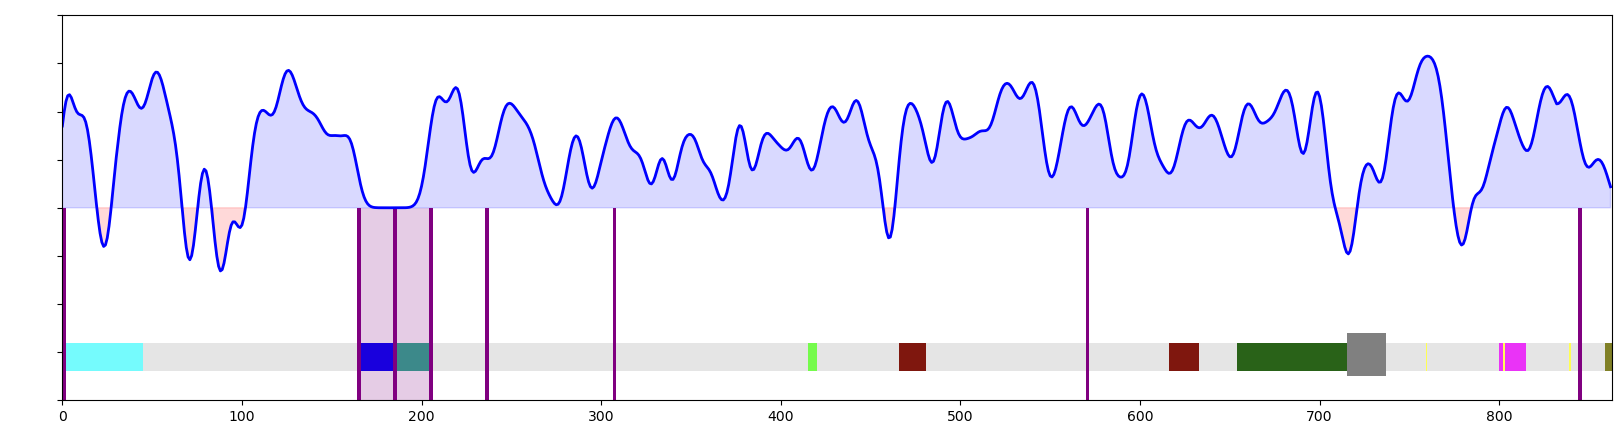

MALPRCTWPNYVWRAVMACLVHRGLGAPLTLCMLGCLLQAGHVLSQKLDDVDPLVATNFGKIRGIKKELNNEILGPVIQFLGVPYAAPPTGERRFQPPEPPSPWSDIRNATQFAPVCPQNIIDGRLPEVMLPVWFTNNLDVVSSYVQDQSEDCLYLNIYVPTEDVKRISKECARKPGKKICRKGGPLTKKQTDDLGDNDGAEDEDIRDSGGPKPVMVYIHGGSYMEGTGNLYDGSVLASYGNVIVITVNYRLGVLGFLSTGDQAAKGNYGLLDLIQALRWTSENIGFFGGDPLRITVFGSGAGGSCVNLLTLSHYSEGNRWSNSTKGLFQRAIAQSGTALSSWAVSFQPAKYARMLATKVGCNVSDTVELVECLQKKPYKELVDQDIQPARYHIAFGPVIDGDVIPDDPQILMEQGEFLNYDIMLGVNQGEGLKFVENIVDSDDGISASDFDFAVSNFVDNLYGYPEGKDVLRETIKFMYTDWADRHNPETRRKTLLALFTDHQWVAPAVATADLHSNFGSPTYFYAFYHHCQTDQVPAWADAAHGDEVPYVLGIPMIGPTELFPCNFSKNDVMLSAVVMTYWTNFAKTGDPNQPVPQDTKFIHTKPNRFEEVAWTRYSQKDQLYLHIGLKPRVKEHYRANKVNLWLELVPHLHNLNDISQYTSTTTKVPSTDITFRPTRKNSVPVTSAFPTAKQDDPKQQPSPFSVDQRDYSTELSVTIAVGASLLFLNILAFAALYYKKDKRRHDVHRRCSPQRTTTNDLTHAQEEEIMSLQMKHTDLDHECESIHPHEVVLRTACPPDYTLAMRRSPDDVPLMTPNTITMIPNTIPGIQPLHTFNTFTGGQNNTLPHPHPHPHSHSTTRV


In [8]:
gene_name = "NLGN1"
prot_len = nlgn1_len

print("gene: "+ gene_name)
#'/GitHub_Upload/variant_data/'+gene_name+'_gnomad_v4.1.0.csv'
gnomad_v4 = pd.read_csv("variant_data/"+gene_name+"_gnomad_v4.1.0.csv")
#get dataframe of only missense variants and add a column with variants in clinvar formatting (i.e. T236V)
gnomad_missense_df = drop_extra_gnomad_columns(add_clinvar_format_variant_to_gnomad_df(gnomad_extract_missense_rows(gnomad_v4,nlgn1_transcript_id,True)))
gnomad_truncations_df = drop_extra_gnomad_columns(extract_gnomad_truncation_variants(gnomad_v4))

clinvar_df =  add_clinvar_missense_MANE_column(pd.read_table("variant_data/"+gene_name+"_clinvar.txt"))
clinvar_missense_df = extract_clinvar_missense_variants(clinvar_df)
clinvar_truncation_df = extract_clinvar_truncation_variants(clinvar_df)
clinvar_missense_list = clinvar_extract_residue_numbers(clinvar_missense_df)
gnomad_missense_list = gnomad_extract_residue_numbers(gnomad_missense_df)

for i in range(len(gnomad_missense_list)):
    # if gnomad_missense_list[i] > 163:
    #     gnomad_missense_list[i]+=20
    if gnomad_missense_list[i] > 163:
        gnomad_missense_list[i]+=40
for i in range(len(clinvar_missense_list)):
    # if gnomad_missense_list[i] > 163:
    #     gnomad_missense_list[i]+=20
    if clinvar_missense_list[i] > 163:
        clinvar_missense_list[i]+=40
clinvar_missense_indexed_list = assemble_indexed_residue_list(clinvar_missense_list,prot_len)
gnomad_missense_indexed_list = assemble_indexed_residue_list(gnomad_missense_list,prot_len)


clinvar_y,gnomad_y = convolve_v3(clinvar_missense_indexed_list,prot_len,31),convolve_v3(gnomad_missense_indexed_list,prot_len,31)

fig, ax = plt.subplots()
x = np.arange(0,prot_len,1)

clinvar_y = [float(i)/max(clinvar_y) for i in clinvar_y]
gnomad_y = [float(i)/max(gnomad_y) for i in gnomad_y]


ax.plot(x, clinvar_y, linewidth=2.0,color='red')
ax.fill_between(x, clinvar_y,color="r",alpha=.15)
ax.plot(x, gnomad_y, linewidth=2.0,color='blue')
ax.fill_between(x, gnomad_y,color="b",alpha=.15)
plt.axis([0,prot_len, 0,1]) 
plt.rcParams['figure.figsize'] = [20, 5]
#plt.xticks(color='w')
plt.yticks(color='w')
plt.show()


y_diff = np.subtract(gnomad_y, clinvar_y)
 
fig, ax = plt.subplots()
plt.axis([0,prot_len, -1,1]) 
plt.rcParams['figure.figsize'] = [20, 5]
#plt.xticks(color='w')
plt.yticks(color='w')

ax.plot(x, y_diff, linewidth=2.0,color='blue')
ax.fill_between(x, y_diff,
        where = y_diff>0, color="b",alpha=.15)
ax.fill_between(x, y_diff,
        where = y_diff<0, color="r",alpha=.15)

#for NLGN1 <---- currently
rect_y = -.85
rect_height = .15

ax.add_patch(Rectangle((0,rect_y), prot_len, rect_height, facecolor = 'gray',alpha=.2))
ax.add_patch(Rectangle((0,rect_y),45, rect_height, facecolor = '#75FBFD'))#signal peptide
ax.add_patch(Rectangle((165,rect_y),20, rect_height, facecolor = '#0000f5'))#splice site A1
ax.add_patch(Rectangle((165,-1),40, 1, facecolor = 'purple',alpha = .2))#grayed out region to indicate no gnomad variants
ax.add_patch(Rectangle((185,rect_y),20, rect_height, facecolor = '#3C898A'))#splice site A2
ax.add_patch(Rectangle((415,rect_y),5, rect_height, facecolor = '#75fb4c'))#NRXN binding interface
ax.add_patch(Rectangle((466,rect_y),15, rect_height, facecolor = '#7F170E'))#Dimerization interface
ax.add_patch(Rectangle((616,rect_y),17, rect_height, facecolor = '#7F170E'))#Dimerization interface
ax.add_patch(Rectangle((654,rect_y),61, rect_height, facecolor = '#296218'))#Juxtamembrane domain
ax.add_patch(Rectangle((715,rect_y-.025),22, rect_height*1.5, facecolor = 'grey'))#Transmembrane domain
ax.add_patch(Rectangle((800,rect_y),15, rect_height, facecolor = '#EA33F7'))#Gephyrin binding domain
ax.add_patch(Rectangle((759,rect_y),1, rect_height, facecolor = '#FFFF54'))#Phosphorylation site
ax.add_patch(Rectangle((839,rect_y),1, rect_height, facecolor = '#FFFF54'))#Phosphorylation site
ax.add_patch(Rectangle((802,rect_y),1, rect_height, facecolor = '#FFFF54'))#Phosphorylation site
ax.add_patch(Rectangle((859,rect_y),4, rect_height, facecolor = '#808026'))#PDZ domain

NLGN1_exon_coor = [0,493,553,553+60,706,919,1709,2532]
for i in range(len(NLGN1_exon_coor)):
    ax.add_patch(Rectangle((NLGN1_exon_coor[i]/3,-1),2 , 1, facecolor = "purple"))


#hashes for barcoding the location of each instance of a missense variants
# for i in range(prot_len):
#     if clinvar_missense_indexed_list[i] > 0:
#         ax.add_patch(Rectangle((i,-1),0.8, 0.05, facecolor = 'black'))
#     if gnomad_missense_indexed_list[i] > 0:
#         ax.add_patch(Rectangle((i,-.95),0.8, 0.05, facecolor='blue'))
plt.show()

print (underline_sensitive_regions(nlgn1_seq,y_diff))

Gene = NLGN2


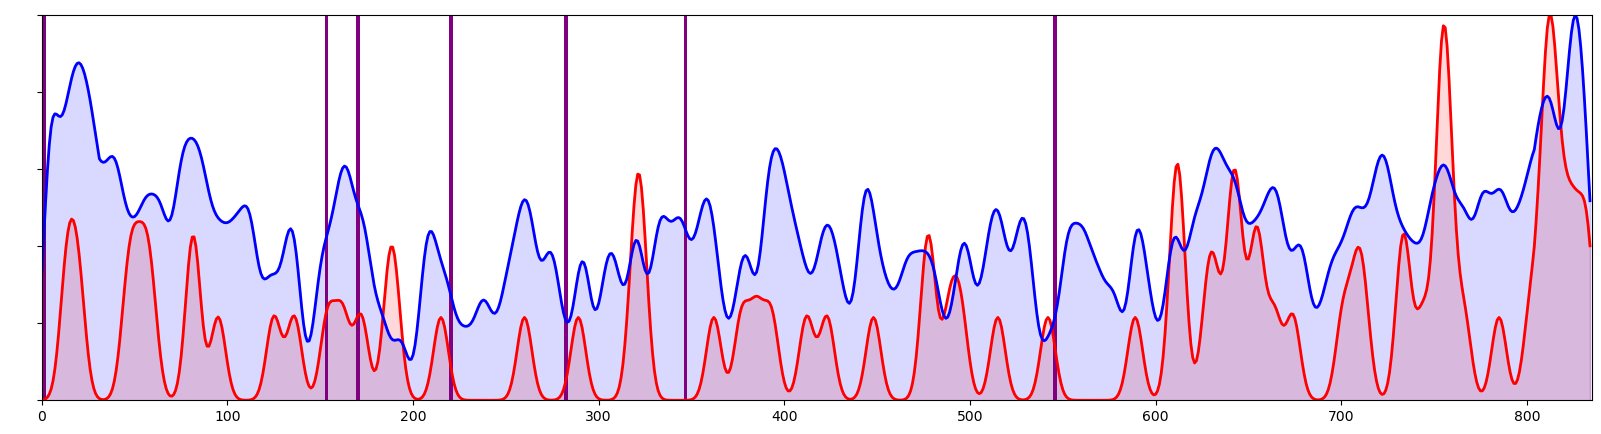

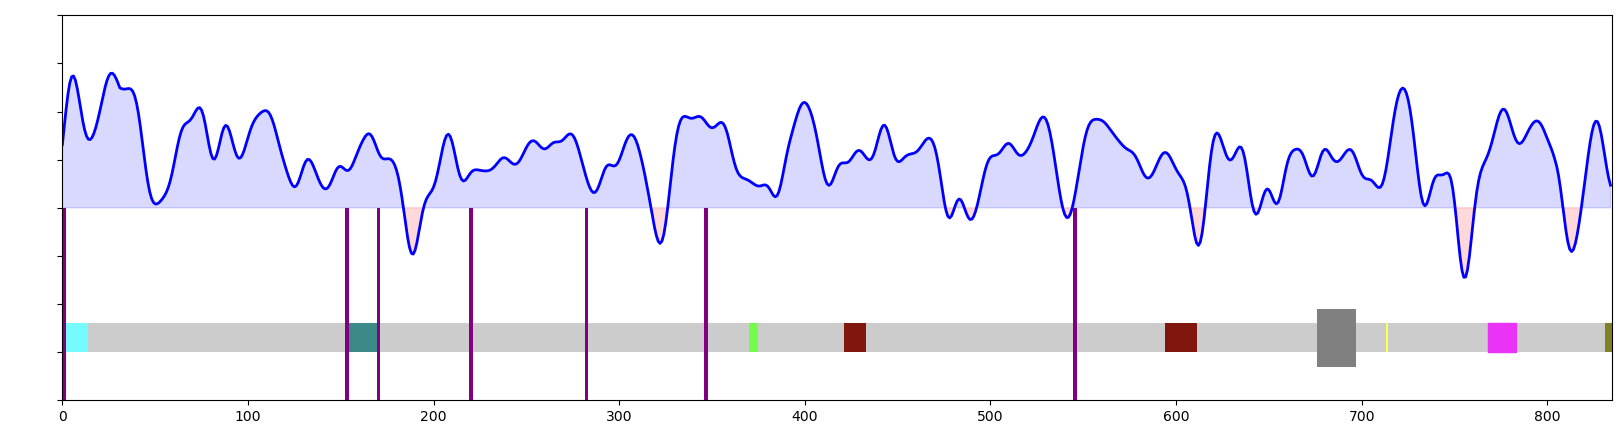

In [9]:

gene_name = "NLGN2"
prot_len = 835
print("Gene = "+gene_name)

gnomad_v4 = pd.read_csv("variant_data/"+gene_name+"_gnomad_v4.1.0.csv")
#get dataframe of only missense variants and add a column with variants in clinvar formatting (i.e. T236V)
gnomad_missense_df = drop_extra_gnomad_columns(add_clinvar_format_variant_to_gnomad_df(gnomad_extract_missense_rows(gnomad_v4,nlgn2_transcript_id,True)))
gnomad_truncations_df = drop_extra_gnomad_columns(extract_gnomad_truncation_variants(gnomad_v4))

clinvar_df =  add_clinvar_missense_MANE_column(pd.read_table("variant_data/"+gene_name+"_clinvar.txt"))
clinvar_missense_df = extract_clinvar_missense_variants(clinvar_df)
clinvar_truncation_df = extract_clinvar_truncation_variants(clinvar_df)
clinvar_missense_list = clinvar_extract_residue_numbers(clinvar_missense_df)
gnomad_missense_list = gnomad_extract_residue_numbers(gnomad_missense_df)
clinvar_missense_indexed_list = assemble_indexed_residue_list(clinvar_missense_list,prot_len)
gnomad_missense_indexed_list = assemble_indexed_residue_list(gnomad_missense_list,prot_len)


clinvar_y,gnomad_y = convolve_v3(clinvar_missense_indexed_list,prot_len,31),convolve_v3(gnomad_missense_indexed_list,prot_len,31)

fig, ax = plt.subplots()
x = np.arange(0,prot_len,1)

clinvar_y = [float(i)/max(clinvar_y) for i in clinvar_y]
gnomad_y = [float(i)/max(gnomad_y) for i in gnomad_y]


ax.plot(x, clinvar_y, linewidth=2.0,color='red')
ax.fill_between(x, clinvar_y,color="r",alpha=.15)
ax.plot(x, gnomad_y, linewidth=2.0,color='blue')
ax.fill_between(x, gnomad_y,color="b",alpha=.15)
NLGN2_exon_coor = [0,457,508,658,844,1037,1634,2508]
for i in range(len(NLGN2_exon_coor)):
    ax.add_patch(Rectangle((NLGN2_exon_coor[i]/3,0),2 , 1, facecolor = "purple"))
    
plt.axis([0,prot_len, 0,1]) 
plt.rcParams['figure.figsize'] = [20, 5]
#plt.xticks(color='w')
plt.yticks(color='w')





# for i in range(prot_len):
#     if clinvar_missense_indexed_list[i] > 0:
#         ax.add_patch(Rectangle((i,0),0.8, 0.05, facecolor = 'black'))
#     if gnomad_missense_indexed_list[i] > 0:
#         ax.add_patch(Rectangle((i,.95),0.8, 0.05, facecolor='black'))
    



plt.show()


y_diff = np.subtract(gnomad_y, clinvar_y)

fig, ax = plt.subplots()
plt.axis([0,prot_len, -1,1]) 
plt.rcParams['figure.figsize'] = [20, 5]
#plt.xticks(color='w')
plt.yticks(color='w')

ax.plot(x, y_diff, linewidth=2.0,color='blue')
ax.fill_between(x, y_diff,
        where = y_diff>0, color="b",alpha=.15)
ax.fill_between(x, y_diff,
        where = y_diff<0, color="r",alpha=.15)
tmp1 = 0
tmp2 = 0

#for NLGN2 
rect_y = -.75
rect_height = .15
ax.add_patch(Rectangle((0,rect_y), prot_len, rect_height, facecolor = 'gray',alpha=.4))
ax.add_patch(Rectangle((0,rect_y),14, rect_height, facecolor = '#75FBFD'))#signal peptide

ax.add_patch(Rectangle((370,rect_y),5, rect_height, facecolor = '#75fb4c'))#NRXN binding interface
ax.add_patch(Rectangle((421,rect_y),12, rect_height, facecolor = '#7f170e'))#Dimerization interface
ax.add_patch(Rectangle((594,rect_y),17, rect_height, facecolor = '#7f170e'))#Dimerization interface
ax.add_patch(Rectangle((153,rect_y),18, rect_height, facecolor = '#3C898A'))#splice site A2

ax.add_patch(Rectangle((676,rect_y-.075),21, rect_height*2, facecolor = 'grey'))#Transmembrane domain
ax.add_patch(Rectangle((713,rect_y),1, rect_height, facecolor = '#FFFF54'))#Phosphorylation site
ax.add_patch(Rectangle((768,rect_y),15, rect_height, color = "#EA33F7"))#Gephyrin binding domain

ax.add_patch(Rectangle((831,rect_y),4, rect_height, facecolor = '#808026'))#PDZ domain

NLGN2_exon_coor = [0,457,508,658,844,1037,1634,2508]
for i in range(len(NLGN2_exon_coor)):
    ax.add_patch(Rectangle((NLGN2_exon_coor[i]/3,-1),2 , 1, facecolor = "purple"))
#plt.show()

gene: NLGN3


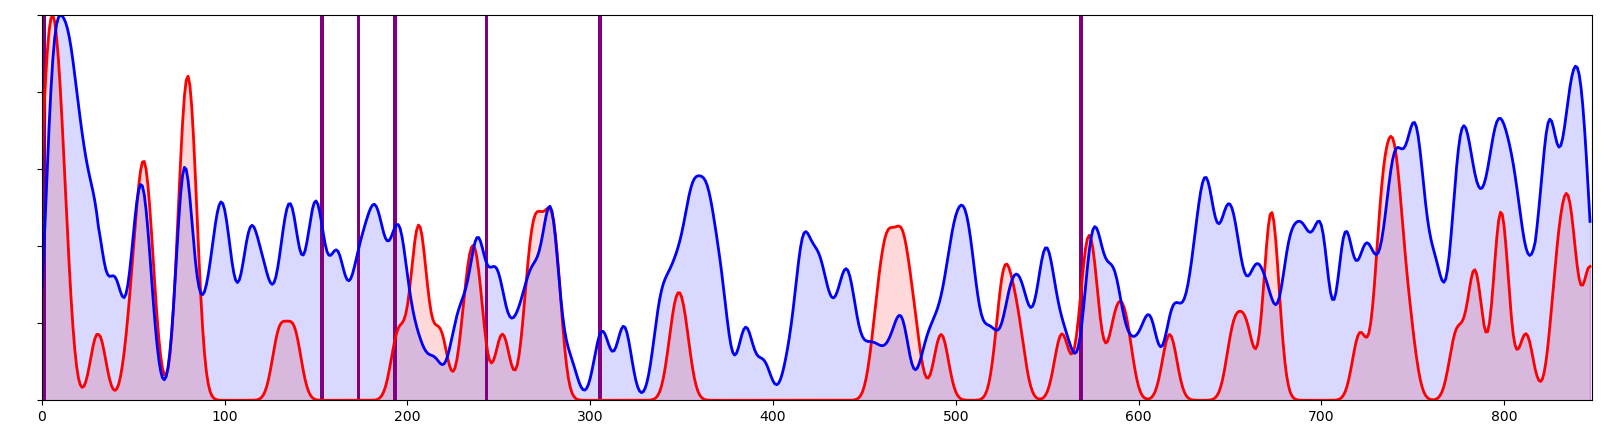

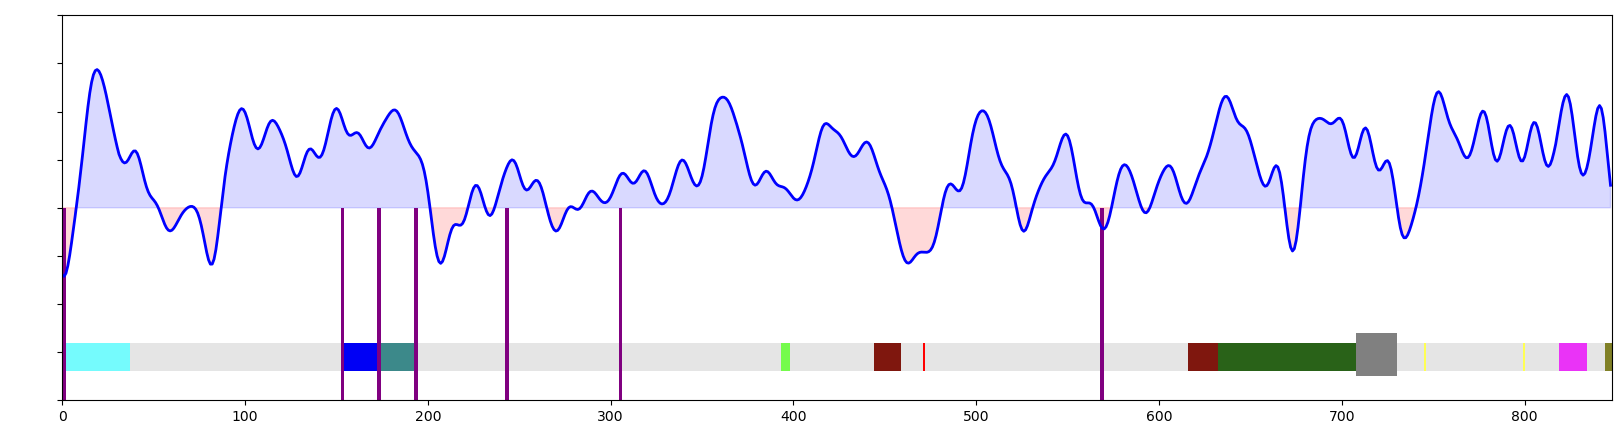

In [10]:
gene_name = "NLGN3"
prot_len = nlgn3_len

print("gene: "+gene_name)
gnomad_v4 = pd.read_csv("variant_data/"+gene_name+"_gnomad_v4.1.0.csv")
#get dataframe of only missense variants and add a column with variants in clinvar formatting (i.e. T236V)
gnomad_missense_df = drop_extra_gnomad_columns(add_clinvar_format_variant_to_gnomad_df(gnomad_extract_missense_rows(gnomad_v4,nlgn3_transcript_id,True)))
gnomad_truncations_df = drop_extra_gnomad_columns(extract_gnomad_truncation_variants(gnomad_v4))

clinvar_df =  add_clinvar_missense_MANE_column(pd.read_table("variant_data/"+gene_name+"_clinvar.txt"))
clinvar_missense_df = extract_clinvar_missense_variants(clinvar_df)
clinvar_truncation_df = extract_clinvar_truncation_variants(clinvar_df)
clinvar_missense_list = clinvar_extract_residue_numbers(clinvar_missense_df)
                                                        
gnomad_missense_list = gnomad_extract_residue_numbers(gnomad_missense_df)
clinvar_missense_indexed_list = assemble_indexed_residue_list(clinvar_missense_list,prot_len)
gnomad_missense_indexed_list = assemble_indexed_residue_list(gnomad_missense_list,prot_len)


female_gnomad_df, male_gnomad_df = seperate_sex_gnomad_variants(gnomad_missense_df)
male_gnomad_list = gnomad_extract_residue_numbers(male_gnomad_df)
gnomad_missense_male_indexed_list = assemble_indexed_residue_list(male_gnomad_list,prot_len)

female_gnomad_list = gnomad_extract_residue_numbers(female_gnomad_df)
gnomad_missense_female_indexed_list = assemble_indexed_residue_list(female_gnomad_list,prot_len)

clinvar_y,gnomad_y = convolve_v3(clinvar_missense_indexed_list,prot_len,31),convolve_v3(gnomad_missense_indexed_list,prot_len,31)

fig, ax = plt.subplots()
x = np.arange(0,prot_len,1)


clinvar_y = [float(i)/max(clinvar_y) for i in clinvar_y]
gnomad_y = [float(i)/max(gnomad_y) for i in gnomad_y]
# offset = len(gnomad_missense_list)/len(clinvar_missense_list)
# clinvar_y = [float(i)*offset for i in clinvar_y]
# gnomad_y = [float(i)/len(clinvar_missense_list)*100 for i in gnomad_y]


ax.plot(x, clinvar_y, linewidth=2.0,color='red')
ax.fill_between(x, clinvar_y,color="r",alpha=.15)
ax.plot(x, gnomad_y, linewidth=2.0,color='blue')
ax.fill_between(x, gnomad_y,color="b",alpha=.15)
NLGN3_exon_coor = [0,457,517,577,727,913,1703,2547]
for i in range(len(NLGN3_exon_coor)):
    ax.add_patch(Rectangle((NLGN3_exon_coor[i]/3,0),2 , 1, facecolor = "purple"))
plt.axis([0,prot_len, 0,1]) 
plt.rcParams['figure.figsize'] = [20, 5]
#plt.xticks(color='w')
plt.yticks(color='w')


plt.show()

y_diff = np.subtract(gnomad_y, clinvar_y)

fig, ax = plt.subplots()
plt.axis([0,prot_len, -1,1]) 
plt.rcParams['figure.figsize'] = [20, 5]
#plt.xticks(color='w')
plt.yticks(color='w')

ax.plot(x, y_diff, linewidth=2.0,color='blue')
ax.fill_between(x, y_diff,
        where = y_diff>0, color="b",alpha=.15)
ax.fill_between(x, y_diff,
        where = y_diff<0, color="r",alpha=.15)


#for NLGN3
rect_y = -.85
rect_height = .15
ax.add_patch(Rectangle((0,rect_y), 848, rect_height, facecolor = 'gray',alpha=.2))
ax.add_patch(Rectangle((0,rect_y),37, rect_height, facecolor = '#75FBFD'))#signal peptide
ax.add_patch(Rectangle((153,rect_y),20, rect_height, facecolor = '#0000f5'))#splice site A1
ax.add_patch(Rectangle((173,rect_y),20, rect_height, facecolor = '#3C898A'))#splice site A2
ax.add_patch(Rectangle((393,rect_y),5, rect_height, facecolor = '#75fb4c'))#NRXN binding interface
ax.add_patch(Rectangle((444,rect_y),15, rect_height, facecolor = '#7F170E'))#Dimerization interface
ax.add_patch(Rectangle((471,rect_y),1, rect_height, facecolor = 'red'))#ASD mutant
ax.add_patch(Rectangle((616,rect_y),16, rect_height, facecolor = '#7F170E'))#Dimerization interface
ax.add_patch(Rectangle((632,rect_y),76, rect_height, facecolor = '#296218'))#Juxtamembrane domain
ax.add_patch(Rectangle((708,rect_y-.025),22, rect_height*1.5, facecolor = 'grey'))#Transmembrane domain
ax.add_patch(Rectangle((819,rect_y),15, rect_height, facecolor = '#EA33F7'))#Gephyrin binding domain
ax.add_patch(Rectangle((799,rect_y),1, rect_height, facecolor = '#FFFF54'))#Phosphorylation site
ax.add_patch(Rectangle((745,rect_y),1, rect_height, facecolor = '#FFFF54'))#Phosphorylation site
ax.add_patch(Rectangle((844,rect_y),4, rect_height, facecolor = '#808026'))#PDZ domain


NLGN3_exon_coor = [0,457,517,577,727,913,1703,2547]
for i in range(len(NLGN3_exon_coor)):
    ax.add_patch(Rectangle((NLGN3_exon_coor[i]/3,-1),2 , 1, facecolor = "purple"))

# for i in range(prot_len):
#     if clinvar_missense_indexed_list[i] > 0:
#         ax.add_patch(Rectangle((i,0),0.8, 0.05, facecolor = 'black'))
#     if gnomad_missense_indexed_list[i] > 0:
#         ax.add_patch(Rectangle((i,.95),0.8, 0.05, facecolor='black'))
    



Gene = NLGN4X


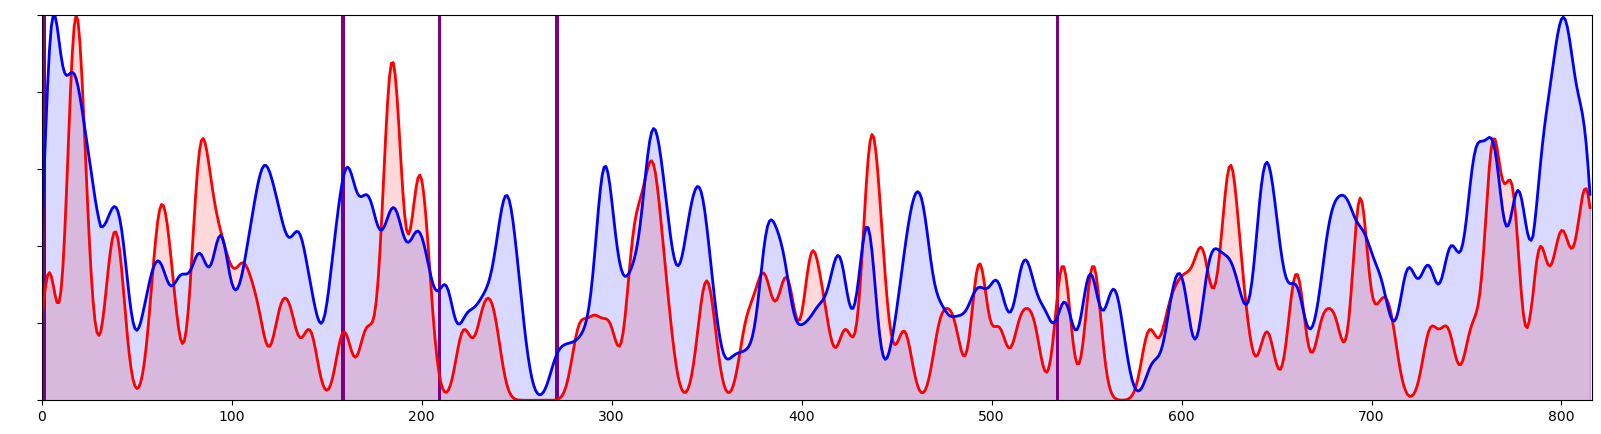

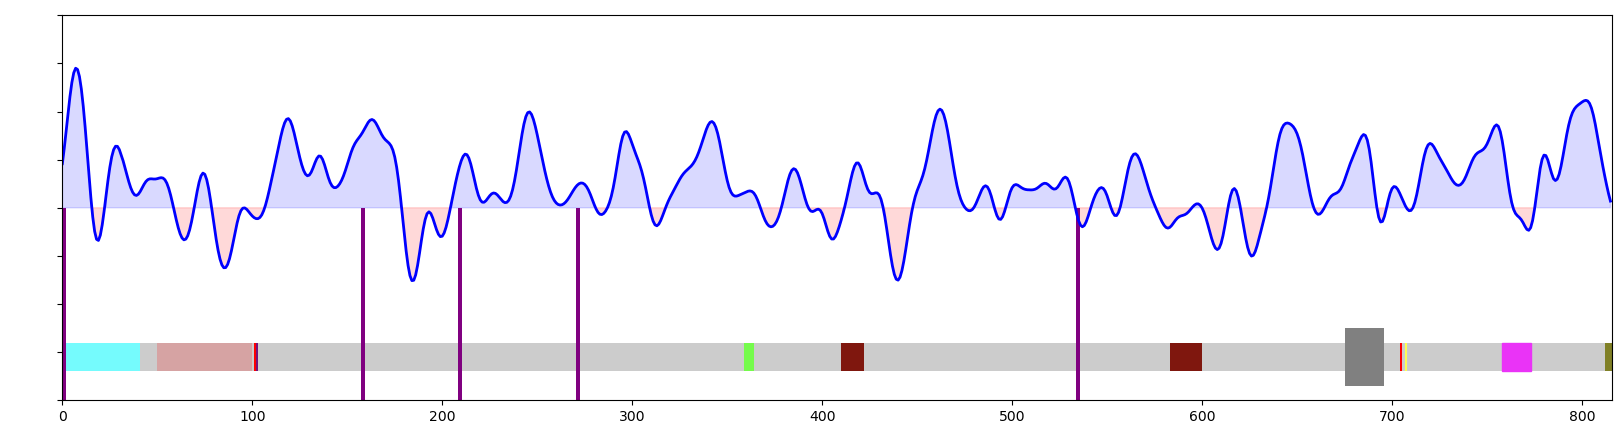

In [13]:
gene_name = "NLGN4X"
prot_len = 816

print("Gene = " + gene_name)

gnomad_v4 = pd.read_csv("variant_data/"+gene_name+"_gnomad_v4.1.0.csv")



#get dataframe of only missense variants and add a column with variants in clinvar formatting (i.e. T236V)
gnomad_missense_df = drop_extra_gnomad_columns(add_clinvar_format_variant_to_gnomad_df(gnomad_extract_missense_rows(gnomad_v4,nlgn4x_transcript_id,True)))
gnomad_truncations_df = drop_extra_gnomad_columns(extract_gnomad_truncation_variants(gnomad_v4))




clinvar_df =  add_clinvar_missense_MANE_column(pd.read_table("variant_data/"+gene_name+"_clinvar.txt"))
clinvar_missense_df = extract_clinvar_missense_variants(clinvar_df)
clinvar_truncation_df = extract_clinvar_truncation_variants(clinvar_df)
clinvar_missense_list = clinvar_extract_residue_numbers(clinvar_missense_df)
gnomad_missense_list = gnomad_extract_residue_numbers(gnomad_missense_df)


clinvar_missense_indexed_list = assemble_indexed_residue_list(clinvar_missense_list,prot_len)
gnomad_missense_indexed_list = assemble_indexed_residue_list(gnomad_missense_list,prot_len)

female_gnomad_df, male_gnomad_df = seperate_sex_gnomad_variants(gnomad_missense_df)
male_gnomad_list = gnomad_extract_residue_numbers(male_gnomad_df)
gnomad_missense_male_indexed_list = assemble_indexed_residue_list(male_gnomad_list,prot_len)
female_gnomad_list = gnomad_extract_residue_numbers(female_gnomad_df)
gnomad_missense_female_indexed_list = assemble_indexed_residue_list(female_gnomad_list,prot_len)

clinvar_y,gnomad_y = convolve_v3(clinvar_missense_indexed_list,prot_len,31),convolve_v3(gnomad_missense_indexed_list,prot_len,31)

fig, ax = plt.subplots()
x = np.arange(0,prot_len,1)

clinvar_y = [float(i)/max(clinvar_y) for i in clinvar_y]
gnomad_y = [float(i)/max(gnomad_y) for i in gnomad_y]


NLGN4X_exon_coor = [0,472,625,811,1601,2451]
for i in range(len(NLGN4X_exon_coor)):
    ax.add_patch(Rectangle((NLGN4X_exon_coor[i]/3,0),2 , 1, facecolor = "purple"))
    
ax.plot(x, clinvar_y, linewidth=2.0,color='red')
ax.fill_between(x, clinvar_y,color="r",alpha=.15)
ax.plot(x, gnomad_y, linewidth=2.0,color='blue')
ax.fill_between(x, gnomad_y,color="b",alpha=.15)

plt.axis([0,prot_len, 0,1]) 
plt.rcParams['figure.figsize'] = [20, 5]
#plt.xticks(color='w')
plt.yticks(color='w')




# for i in range(prot_len):
#     if clinvar_missense_indexed_list[i] > 0:
#         ax.add_patch(Rectangle((i,0),0.8, 0.05, facecolor = 'black'))
#     if gnomad_missense_indexed_list[i] > 0:
#         ax.add_patch(Rectangle((i,.95),0.8, 0.05, facecolor='black'))
    

# x_min, x_max, y_min, y_max = 50, 100, 0, 1 #<---- line to zoom in on plot
# plt.axis([x_min, x_max, y_min, y_max])#<--- line to zoom in on plot
plt.show()


y_diff = np.subtract(gnomad_y, clinvar_y)

fig, ax = plt.subplots()
plt.axis([0,prot_len, -1,1]) 
plt.rcParams['figure.figsize'] = [20, 5]
#plt.xticks(color='w')
plt.yticks(color='w')

ax.plot(x, y_diff, linewidth=2.0,color='blue')
ax.fill_between(x, y_diff,
        where = y_diff>0, color="b",alpha=.15)
ax.fill_between(x, y_diff,
        where = y_diff<0, color="r",alpha=.15)

#for NLGN4X <---- currently

rect_y = -.85
rect_height = .15

ax.add_patch(Rectangle((0,rect_y), prot_len, rect_height, facecolor = 'gray',alpha=.4))
ax.add_patch(Rectangle((0,rect_y),41, rect_height, facecolor = '#75FBFD'))#signal peptide
ax.add_patch(Rectangle((50,rect_y),50, rect_height, facecolor = 'red',alpha=.2))
ax.add_patch(Rectangle((101,rect_y),1, rect_height, facecolor = 'red'))#R101Q ASD mutant
ax.add_patch(Rectangle((102,rect_y),1, rect_height, facecolor = '#75147C'))#N102 glycosolation site



ax.add_patch(Rectangle((359,rect_y),5, rect_height, facecolor = '#75fb4c'))#NRXN binding interface
ax.add_patch(Rectangle((410,rect_y),12, rect_height, facecolor = '#7f170e'))#Dimerization interface
ax.add_patch(Rectangle((583,rect_y),17, rect_height, facecolor = '#7f170e'))#Dimerization interface

ax.add_patch(Rectangle((675,rect_y-.075),21, rect_height*2, facecolor = 'grey'))#Transmembrane domain
ax.add_patch(Rectangle((704,rect_y),1, rect_height, facecolor = 'red'))#R704C ASD mutant
ax.add_patch(Rectangle((758,rect_y),15, rect_height, color = "#EA33F7"))#Gephyrin binding domain


ax.add_patch(Rectangle((707,rect_y),1, rect_height, facecolor = '#FFFF54'))
ax.add_patch(Rectangle((707,rect_y),1, rect_height, facecolor = '#FFFF54'))

ax.add_patch(Rectangle((812,rect_y),4, rect_height, facecolor = '#808026'))#PDZ domain

NLGN4X_exon_coor = [0,472,625,811,1601,2451]
for i in range(len(NLGN4X_exon_coor)):
    ax.add_patch(Rectangle((NLGN4X_exon_coor[i]/3,-1),2 , 1, facecolor = "purple"))


plt.show()